In [1]:
# Core
import warnings
warnings.filterwarnings("ignore")

import os
import math
from dataclasses import dataclass

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Stats & tests
from statsmodels.tsa.stattools import adfuller, kpss, acf, pacf, zivot_andrews
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Display helper for Jupyter
from IPython.display import display

pd.options.display.float_format = '{:,.6f}'.format
print("Libraries ready.")


Libraries ready.


In [2]:
# Edit DATA_PATH if needed. Expecting two columns: `timestamp`, `value`
DATA_PATH = "TimeSeries_Volatility 25 Index.csv"  # change to your local path if needed

# Load: try with header; fallback to headerless
try:
    df = pd.read_csv(DATA_PATH)
    if df.columns.tolist()[:2] != ["timestamp", "value"]:
        df = pd.read_csv(DATA_PATH, header=None, names=["timestamp","value"])
except Exception:
    df = pd.read_csv(DATA_PATH, header=None, names=["timestamp","value"])

# Parse time & clean
df["timestamp"] = pd.to_datetime(df["timestamp"], errors="coerce")
df = df.dropna(subset=["timestamp", "value"]).sort_values("timestamp").reset_index(drop=True)
df = df.drop_duplicates(subset="timestamp")

ts = df.set_index("timestamp")["value"].astype(float)

print("Rows:", len(ts))
print("Start:", ts.index.min())
print("End  :", ts.index.max())
print("Head:")
print(ts.head())


Rows: 74362
Start: 2017-03-10 00:00:00
End  : 2025-09-02 13:00:00
Head:
timestamp
2017-03-10 00:00:00   2,705.359000
2017-03-10 01:00:00   2,700.699000
2017-03-10 02:00:00   2,699.067000
2017-03-10 03:00:00   2,698.540000
2017-03-10 04:00:00   2,691.977000
Name: value, dtype: float64


In [3]:
deltas = ts.index.to_series().diff().dropna().value_counts().sort_values(ascending=False)
most_common = deltas.index[0] if len(deltas) else None
print("Most common interval:", most_common, "| share:", (deltas.iloc[0]/deltas.sum()*100 if len(deltas) else np.nan), "%")
print("\nTop 5 intervals:")
print(deltas.head(5))

# Gap summary
gaps = ts.index.to_series().diff().dropna()
gap_stats = gaps.describe()
print("\nGap stats:")
print(gap_stats)

# Optional strict grid:
# ts = ts.asfreq(most_common)


Most common interval: 0 days 01:00:00 | share: 99.94889794381463 %

Top 5 intervals:
timestamp
0 days 01:00:00    74323
0 days 01:02:00        3
0 days 00:58:00        3
0 days 00:59:00        2
0 days 00:51:00        2
Name: count, dtype: int64

Gap stats:
count                        74361
mean     0 days 01:00:00.193649897
std      0 days 00:01:01.553998414
min                0 days 00:13:00
25%                0 days 01:00:00
50%                0 days 01:00:00
75%                0 days 01:00:00
max                0 days 05:10:30
Name: timestamp, dtype: object


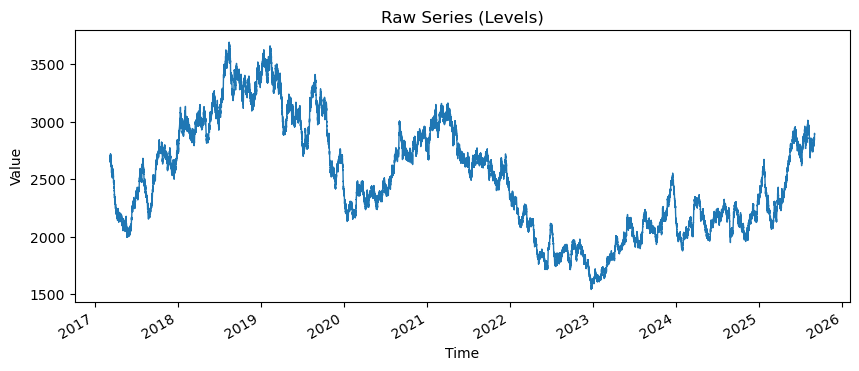

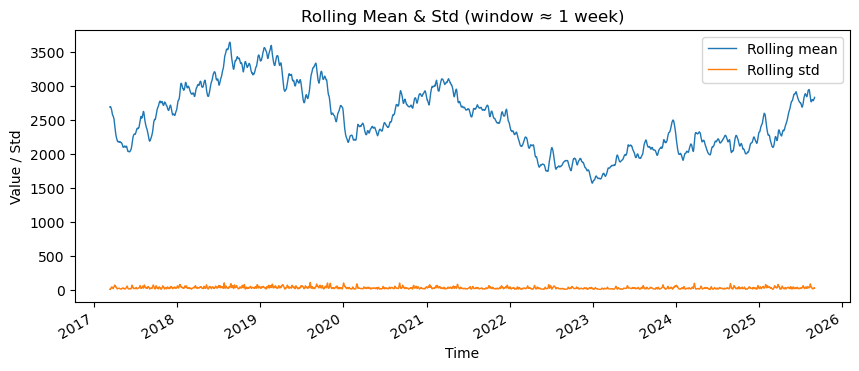

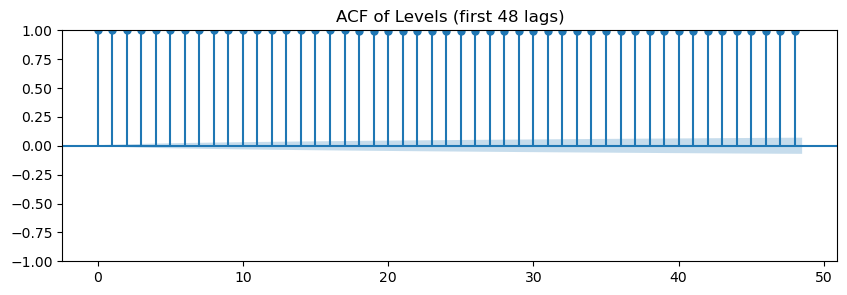

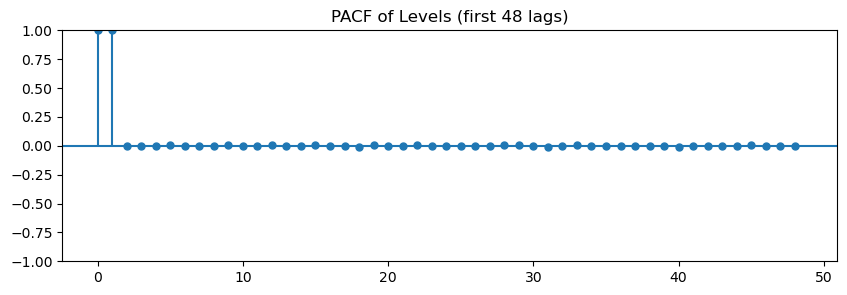

In [4]:
# Raw levels
fig, ax = plt.subplots(figsize=(10, 4))
ts.plot(ax=ax, lw=1)
ax.set_title("Raw Series (Levels)")
ax.set_xlabel("Time"); ax.set_ylabel("Value")
plt.show()

# Rolling mean/std (≈ 1 week window if hourly)
roll = ts.rolling(window=24*7, min_periods=24).agg(['mean','std'])
fig, ax = plt.subplots(figsize=(10, 4))
roll['mean'].plot(ax=ax, lw=1, label="Rolling mean")
roll['std'].plot(ax=ax, lw=1, label="Rolling std")
ax.legend(loc="best")
ax.set_title("Rolling Mean & Std (window ≈ 1 week)")
ax.set_xlabel("Time"); ax.set_ylabel("Value / Std")
plt.show()

# ACF/PACF of levels
fig, ax = plt.subplots(figsize=(10, 3))
plot_acf(ts.dropna(), lags=48, ax=ax)
ax.set_title("ACF of Levels (first 48 lags)")
plt.show()

fig, ax = plt.subplots(figsize=(10, 3))
plot_pacf(ts.dropna(), lags=48, ax=ax, method="ywm")
ax.set_title("PACF of Levels (first 48 lags)")
plt.show()
